#### Import required libraries and define main varaibles

In [34]:
%matplotlib inline

import numpy as np
import cv2
import os
import imutils
import random
import easyocr
import xml.etree.ElementTree as xet
import pandas as pd

from glob import glob
from matplotlib import pyplot as plt

IMAGE_SIZE = 224

#### Parse data from XML annotations, resize annotations, resize images and saving all the data into CSV file (and pandas dataframe)

In [2]:
# Dictionary
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[],width=[],height=[],nxmin=[],nxmax=[],nymin=[],nymax=[], X=[], y=[])

# Get list of XML files in the annotations folder
path = glob('./data/annotations/*.xml')

# Images folder
image_folder = './data/images/'

for filename in path:
    info = xet.parse(filename)
    root = info.getroot()

    # Get width and height from the XML    
    member_object = root.find('size')
    width = member_object.find('width').text
    height = member_object.find('height').text
  
    # Get xmin, xmax, ymin, ymax from the XML
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = labels_info.find('xmin').text
    xmax = labels_info.find('xmax').text
    ymin = labels_info.find('ymin').text
    ymax = labels_info.find('ymax').text
    
    # Cast to integer
    xmin = int(float(xmin))
    xmax = int(float(xmax))
    ymin = int(float(ymin))
    ymax = int(float(ymax))   
    
    # Get filename from the XML
    image_filename = xet.parse(filename).getroot().find('filename').text
    image_fullname = os.path.join(image_folder,image_filename)

    # Append filename, xmin, xmax, ymin, ymax to the dictionary
    labels_dict['filepath'].append(image_fullname)    
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Append width and height of the image to the dictionary
    labels_dict['width'].append(width)
    labels_dict['height'].append(height)

    # Normalize annotation to fit the resized image 
    nxmin = int(float(xmin)) / (int(width) / IMAGE_SIZE)
    nymin = int(float(ymin)) / (int(height) / IMAGE_SIZE)
    nxmax = int(float(xmax)) / (int(width) / IMAGE_SIZE)
    nymax = int(float(ymax)) / (int(height) / IMAGE_SIZE)            

    # Append normalized annotations to the dictionary
    labels_dict['nxmin'].append(int(nxmin))
    labels_dict['nxmax'].append(int(nxmax))
    labels_dict['nymin'].append(int(nymin))
    labels_dict['nymax'].append(int(nymax))

    # Read file, resize image and save its array
    img = cv2.imread(image_fullname)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))

    # Append X values (images' array)
    labels_dict['X'].append(np.array(img))    

    # Append y values (bounding boxes)
    labels_dict['y'].append(np.array([int(nxmin),int(nxmax), int(nymin), int(nymax)]))  

# Create a pandas dataframe with all the info
df = pd.DataFrame(labels_dict)

df.to_csv('labels.csv',index=False)
df.head(10)    

filepath  xmin  xmax  ymin  ymax width height  nxmin  nxmax  \
0  ./data/images/001.jpg  1105  1570  1143  1278  2304   1728    107    152   
1  ./data/images/002.jpg   428   604   330   376  1024    768     93    132   
2  ./data/images/003.jpg   213   405   308   362   700    464     68    129   
3  ./data/images/004.jpg   304   509   402   452   800    600     85    142   
4  ./data/images/005.jpg   327   520   260   314   800    600     91    145   
5  ./data/images/006.jpg   279   411   320   352   700    464     89    131   
6  ./data/images/007.jpg   256   419   290   338   700    464     81    134   
7  ./data/images/008.jpg   240   388   330   374   667    500     80    130   
8  ./data/images/009.jpg   125   237   390   460   800    600     35     66   
9  ./data/images/010.jpg   244   391   328   371   667    500     81    131   

   nymin  nymax                                                  X  \
0    148    165  [[[174, 174, 168], [175, 169, 164], [33, 42, 3...   
1     96    109  [[[251, 228, 180], [254, 229, 179], [252, 225,...   
2    148    174  [[[32, 17, 74], [32, 19, 75], [31, 17, 75], [3...   
3    150    168  [[[118, 150, 159], [115, 151, 157], [114, 151,...   
4     97    117  [[[66, 72, 71], [66, 72, 71], [62, 71, 70], [6...   
5    154    169  [[[21, 26, 29], [22, 23, 27], [18, 19, 23], [1...   
6    140    163  [[[182, 175, 172], [183, 175, 175], [184, 176,...   
7    147    167  [[[130, 158, 177], [125, 157, 175], [123, 156,...   
8    145    171  [[[229, 215, 209], [227, 213, 207], [225, 211,...   
9    146    166  [[[67, 108, 147], [60, 103, 144], [59, 102, 14...   

                      y  
0  [107, 152, 148, 165]  
1    [93, 132, 96, 109]  
2   [68, 129, 148, 174]  
3   [85, 142, 150, 168]  
4    [91, 145, 97, 117]  
5   [89, 131, 154, 169]  
6   [81, 134, 140, 163]  
7   [80, 130, 147, 167]  
8    [35, 66, 145, 171]  
9   [81, 131, 146, 166]

#### Preview dataset

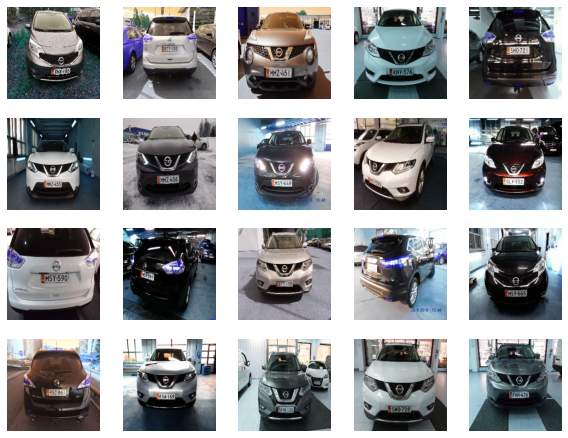

In [3]:
# Print the first 20 resized images
plt.figure(figsize=(10,20))
for i in range(0,20) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(df['X'].values[i])

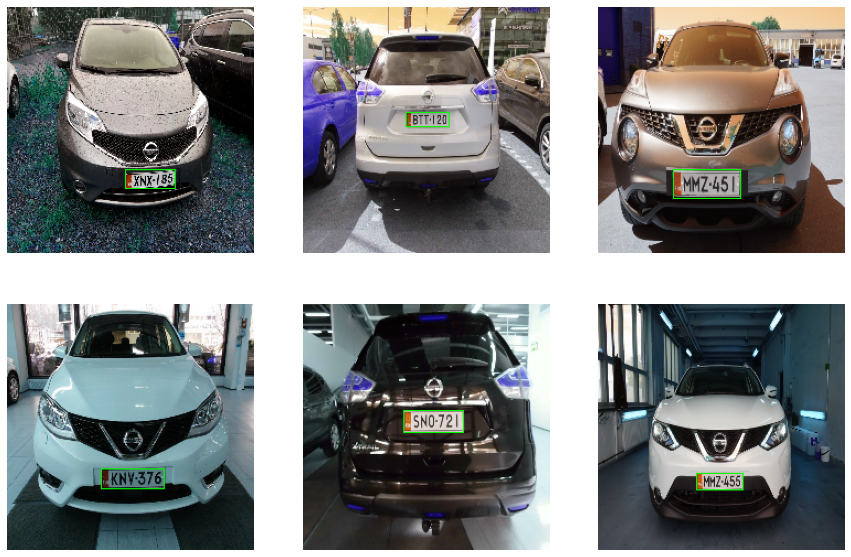

In [4]:
# Print the first 6 images including bounding boxes
plt.figure(figsize=(15,10))
for i in range(0,6) :
    plt.subplot(2,3,i+1)
    plt.axis('off')
    
    #(x1,y1)(x2,y2)
    image = cv2.rectangle(df['X'].values[i],(df['y'].values[i][0],df['y'].values[i][2]),(df['y'].values[i][1],df['y'].values[i][3]),(0, 255, 0))
    plt.imshow(image)

#### Split data into train, val and test: 
- *60% - train set* 
- *20% - validation set* 
- *20% - test set*


In [17]:
train, val, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

In [18]:
print(train.shape, val.shape, test.shape)

(180, 13) (60, 13) (60, 13)


#### Preparing the data for the CNN

In [19]:
# Read files, resize images, normalize and save them into an array
X_train=[]
for file in train['filepath']:   
    img = cv2.imread(file)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X_train.append(np.array(img)/255)

X_val=[]
for file in val['filepath']:   
    img = cv2.imread(file)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X_val.append(np.array(img)/255)

X_test=[]
for file in test['filepath']:   
    img = cv2.imread(file)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X_test.append(np.array(img)/255)            

In [20]:
#Transforming to array
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)
X_train.shape

# Printing shapes
print(X_train.shape, X_val.shape, X_test.shape)

(180, 224, 224, 3) (60, 224, 224, 3) (60, 224, 224, 3)


In [21]:
# Read resizeed boundingnboxes, normalize and save them into an array
y_train=[]
for i in range(0, len(train)):
    nxmin = int(train['nxmin'].values[i])
    nxmax = int(train['nxmax'].values[i])
    nymin = int(train['nymin'].values[i])
    nymax = int(train['nymax'].values[i]) 
    y_train.append([int(nxmin)/255, int(nxmax)/255, int(nymin)/255, int(nymax)/255])

y_val=[]
for i in range(0, len(val)):
    nxmin = int(val['nxmin'].values[i])
    nxmax = int(val['nxmax'].values[i])
    nymin = int(val['nymin'].values[i])
    nymax = int(val['nymax'].values[i]) 
    y_val.append([int(nxmin)/255, int(nxmax)/255, int(nymin)/255, int(nymax)/255])

y_test=[]
for i in range(0, len(test)):
    nxmin = int(test['nxmin'].values[i])
    nxmax = int(test['nxmax'].values[i])
    nymin = int(test['nymin'].values[i])
    nymax = int(test['nymax'].values[i]) 
    y_test.append([int(nxmin)/255, int(nxmax)/255, int(nymin)/255, int(nymax)/255])

In [22]:
#Transforming to array
y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)
y_train.shape

# Printing shapes
print(y_train.shape, y_val.shape, y_test.shape)

(180, 4) (60, 4) (60, 4)


#### Convolutional Neural Network (CNN)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

# Create the model
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               3211392   
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 17,951,108
Trainable params: 3,236,420
N

In [24]:
# Compile and train the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Add early stopper and fit the model
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1, callbacks =[earlystopping])

Epoch 1/50
6/6 [==============================] - 30s 5s/step - loss: 0.0792 - accuracy: 0.1667 - val_loss: 0.0133 - val_accuracy: 0.8500
Epoch 2/50
6/6 [==============================] - 26s 4s/step - loss: 0.0461 - accuracy: 0.5611 - val_loss: 0.0371 - val_accuracy: 0.4167
Epoch 3/50
6/6 [==============================] - 25s 4s/step - loss: 0.0338 - accuracy: 0.7778 - val_loss: 0.0208 - val_accuracy: 0.1667
Epoch 4/50
6/6 [==============================] - 27s 5s/step - loss: 0.0168 - accuracy: 0.5722 - val_loss: 0.0070 - val_accuracy: 0.7667
Epoch 5/50
6/6 [==============================] - 27s 5s/step - loss: 0.0084 - accuracy: 0.5833 - val_loss: 0.0073 - val_accuracy: 0.7167
Epoch 6/50
6/6 [==============================] - 25s 4s/step - loss: 0.0058 - accuracy: 0.5444 - val_loss: 0.0051 - val_accuracy: 0.3000
Epoch 7/50
6/6 [==============================] - 27s 5s/step - loss: 0.0033 - accuracy: 0.7833 - val_loss: 0.0038 - val_accuracy: 0.8333
Epoch 8/50
6/6 [==================

In [25]:
# Test the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 93.33%


#### Plot model results

In [26]:
def plot_scores(h) :
    accuracy = h.history['accuracy']
    val_accuracy = h.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Train')
    plt.plot(epochs, val_accuracy, 'r', label='Validation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()

In [27]:
def plot_loss(h) :
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Train')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

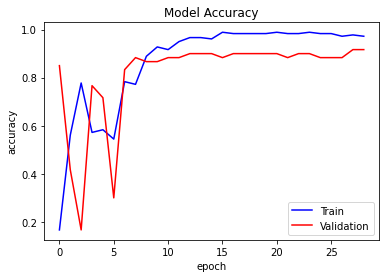

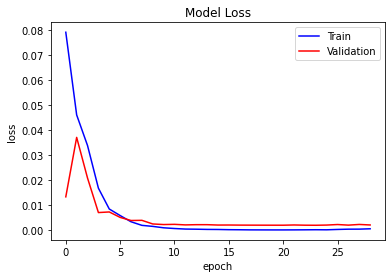

In [28]:
plot_scores(history)
plot_loss(history)

#### Predict bounding boxes in the test set

In [29]:
 y_cnn = model.predict(X_test)

In [30]:
y_cnn.shape

(60, 4)

#### Preview results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

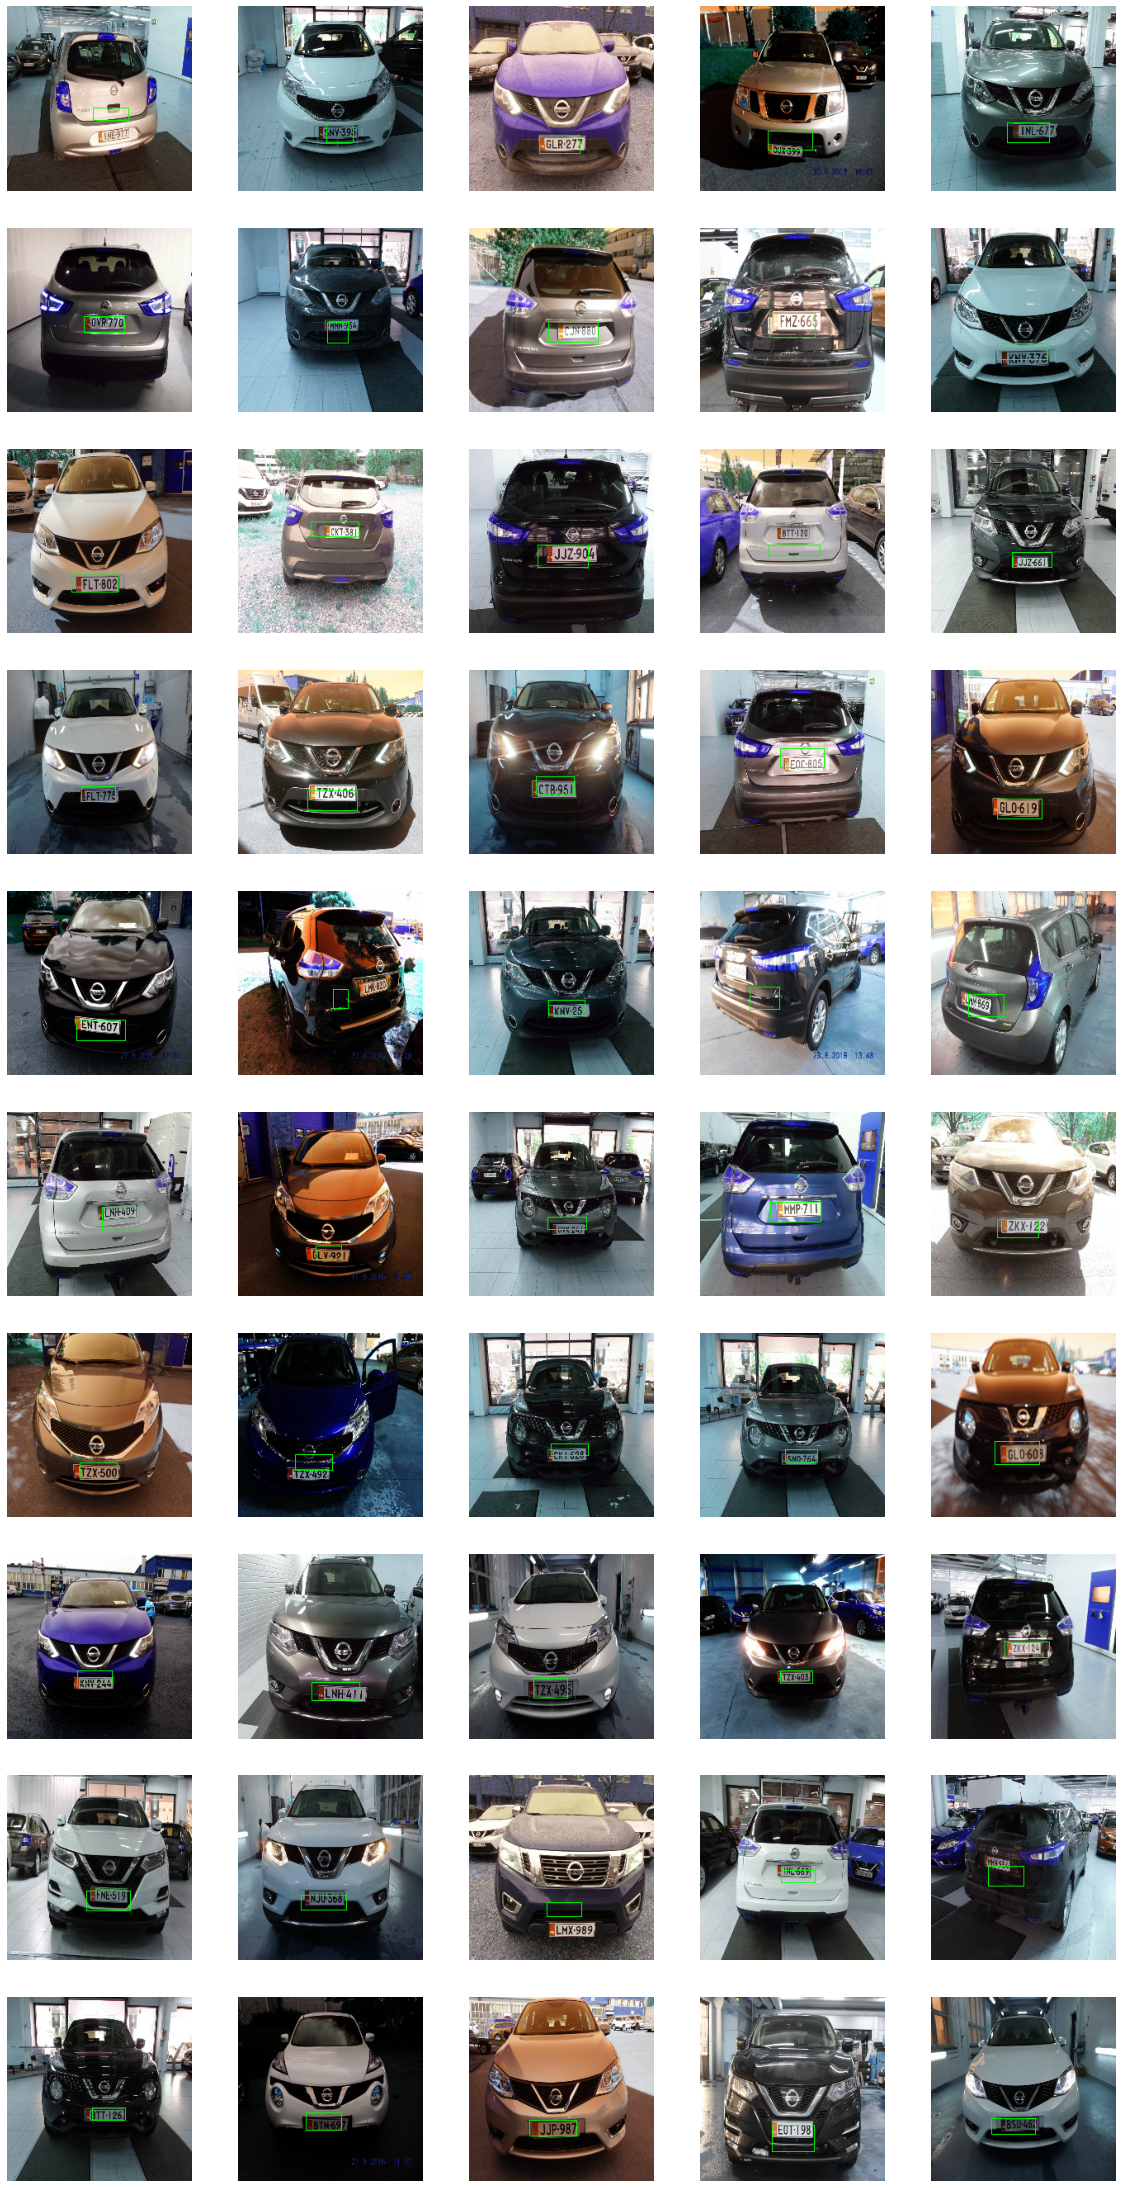

In [31]:
plt.figure(figsize=(20,40))

max = y_cnn.shape[0]
if max > 50:
    max = 50

for i in range(0,max):  
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[2])),(int(ny[1]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)   

#### Crop images around the area of the plate prediction

In [32]:
# Define output folder 
output_folder = './data/output/'

# Get max images in the test set
max = y_cnn.shape[0]

# Range in pixels to crop the image around
RANGE = 0.25

for i in range(0,max):

    # Read image from original folder
    image_name = test['filepath'].values[i]   
    image = cv2.imread(image_name)   
        
    # Get image shape and get the factor to convert to original annotation
    h, w, c = image.shape
    w_ratio = w / IMAGE_SIZE 
    h_ratio = h / IMAGE_SIZE    

    ny = y_cnn[i]*255

    X_range = RANGE * w
    Y_range = RANGE * h

    #(x1,y1)(x2,y2)   
    x1 = int(ny[0]*w_ratio)-X_range
    x2 = int(ny[2]*w_ratio)+X_range
    y1 = int(ny[1]*h_ratio)-Y_range
    y2 = int(ny[3]*h_ratio)+Y_range
    
    if x1 < 0: x1=0
    if y1 < 0: y1=0    
    if x2 > w: x2=w
    if y2 > h: y2=h
    
    #(x1,y1)(x2,y2)
    ##cropped_image = cv2.rectangle(image,(x1,y1),(x2,y2),(0, 255, 3))
    cropped_image = image[int(y1):int(y2),int(x1):int(x2)]      
    ch, cw, cc = cropped_image.shape
    # Create the directory if it does not exist 
    if not (os.path.exists(output_folder)):
        os.makedirs(output_folder)
        
    image_name = image_name.replace('./data/images/','')    
    cv2.imwrite(output_folder + image_name, cropped_image)    
    

#### Preview cropped images

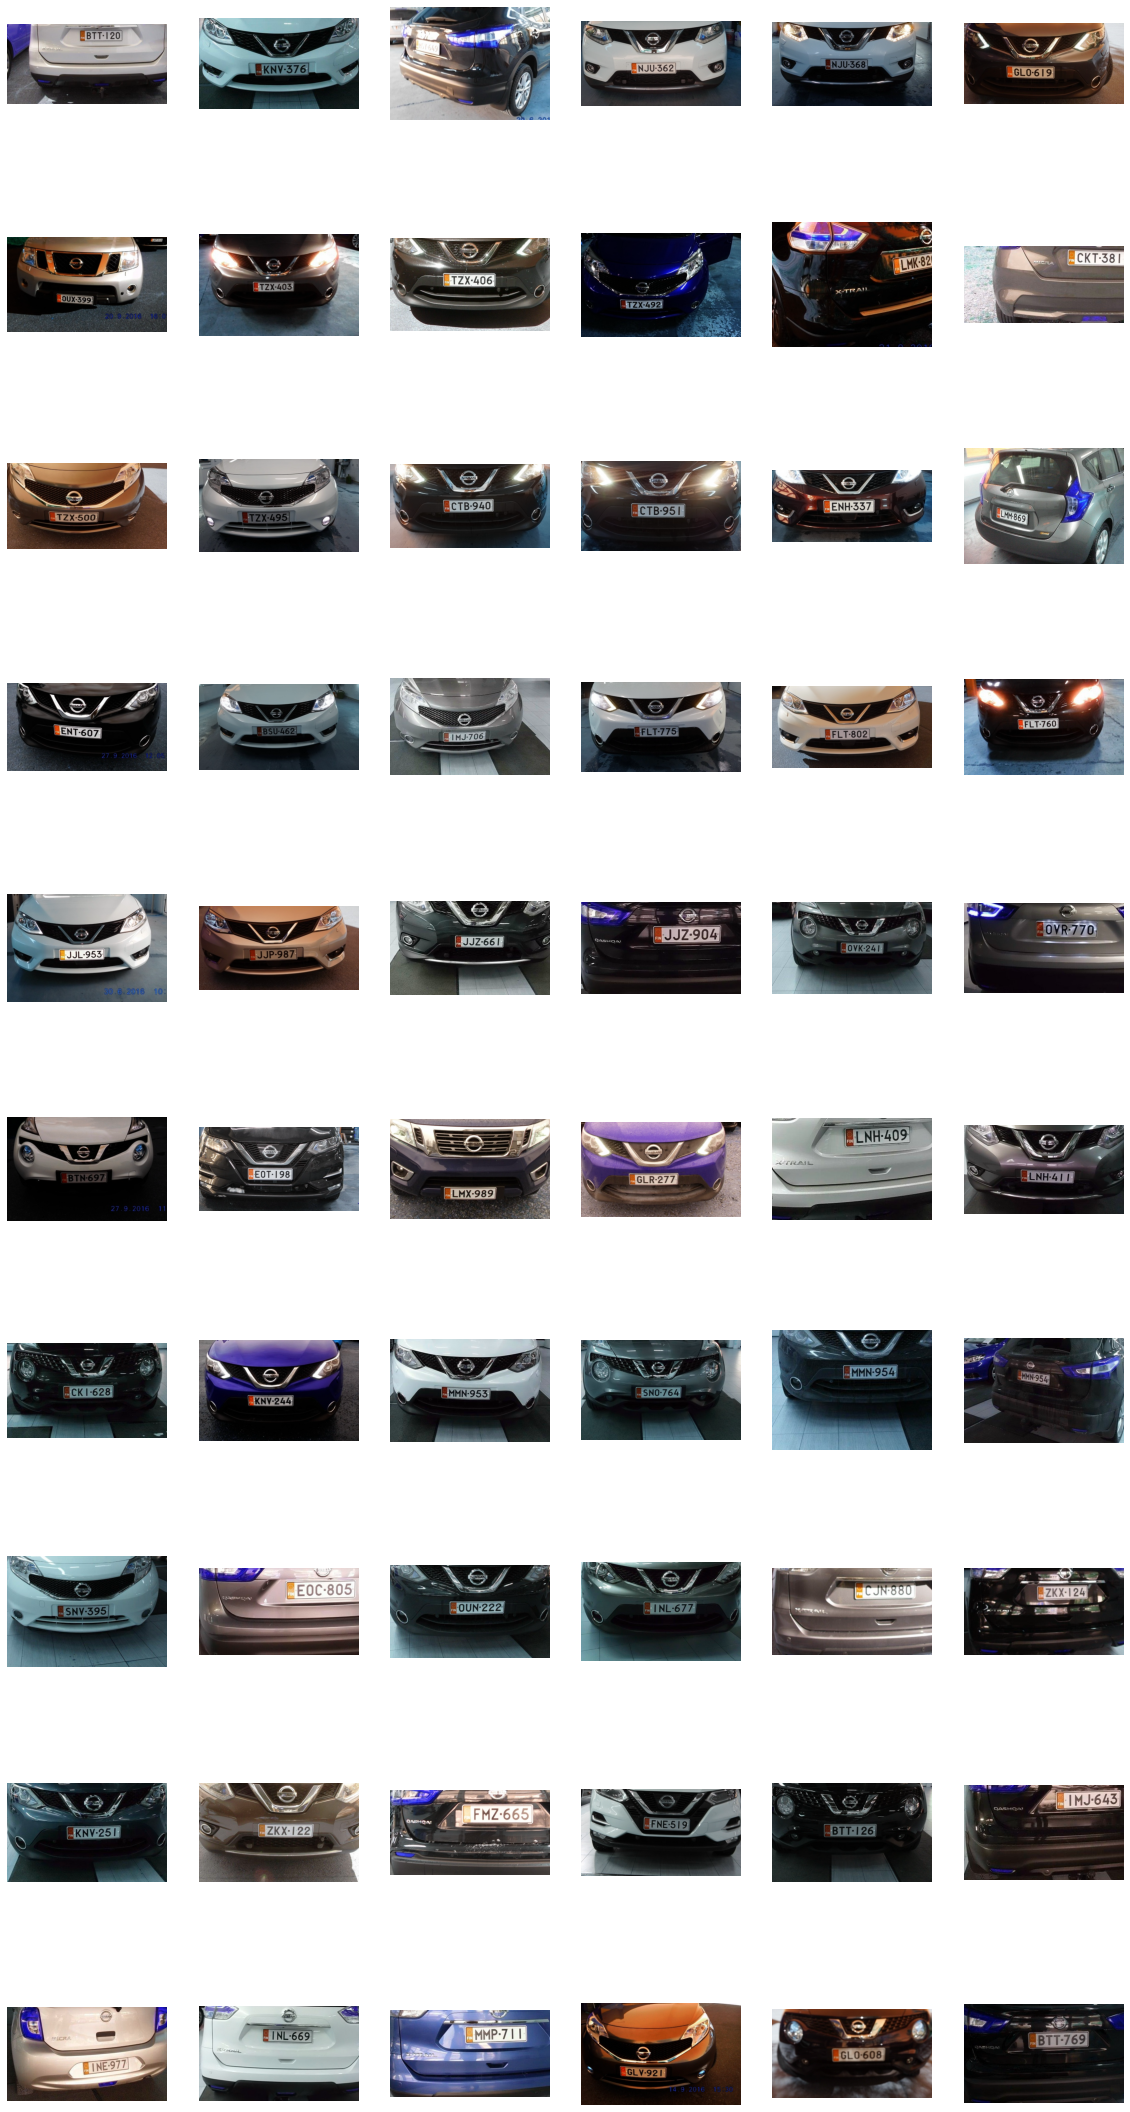

In [33]:
# Get list of XML files in the annotations folder
cropped_images = glob('./data/output/*.jpg')
plt.figure(figsize=(20,40))
index = 0
for f in cropped_images:
    # Read file, resize image and save its array
    img_ = cv2.imread(f)
    # Print the first 20 resized images
    plt.subplot(10,6,index+1)
    plt.axis('off')
    plt.imshow(img_)
    index = index + 1 

#### Read in a randomly selected Image, Grayscale and Blur it

./data/output\215.jpg


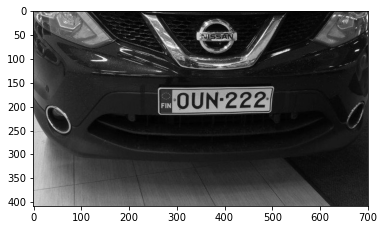

In [77]:
image_name = random.choice(cropped_images)
print(image_name)
img = cv2.imread(image_name)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

#### Apply filter and find edges for localization

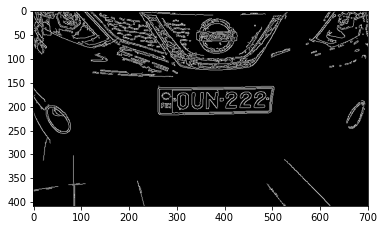

In [78]:
bfilter = cv2.bilateralFilter(gray, 13, 15, 15) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

#### Find Contours and apply mask

In [79]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [80]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [81]:
location

array([[[261, 162]],

       [[267, 217]],

       [[493, 213]],

       [[504, 165]]], dtype=int32)

In [82]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

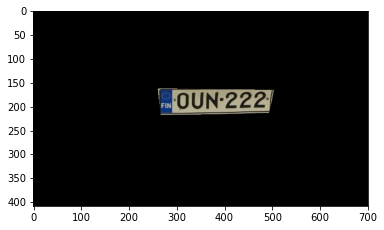

In [83]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

#### Crop image using the mask

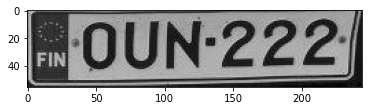

In [84]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

#### Apply EasyOCR to get the text of the plate

In [85]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[5, 29], [31, 29], [31, 43], [5, 43]], 'FINI', 0.856597363948822),
 ([[33, 0], [234, 0], [234, 50], [33, 50]], 'OUN 222', 0.5443363113411477)]

In [86]:
region_threshold = 0.6

In [87]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]

    plate = []

    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))

        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

In [88]:
plate = filter_text(cropped_image, result, region_threshold)

#### Render results

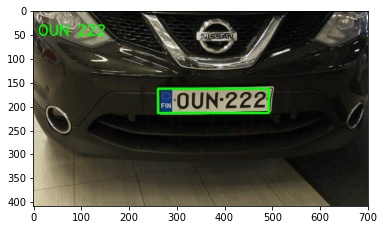

In [89]:
text = plate[0]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(10, 50), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))